In [88]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# 数据预处理

In [89]:
features = pd.read_csv('temps.csv')
features.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


In [90]:
print('数据维度',features.shape)

数据维度 (348, 9)


In [91]:
#处理时间数据
import datetime

years=features['year']
months=features['month']
days=features['day']

dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]

In [92]:
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

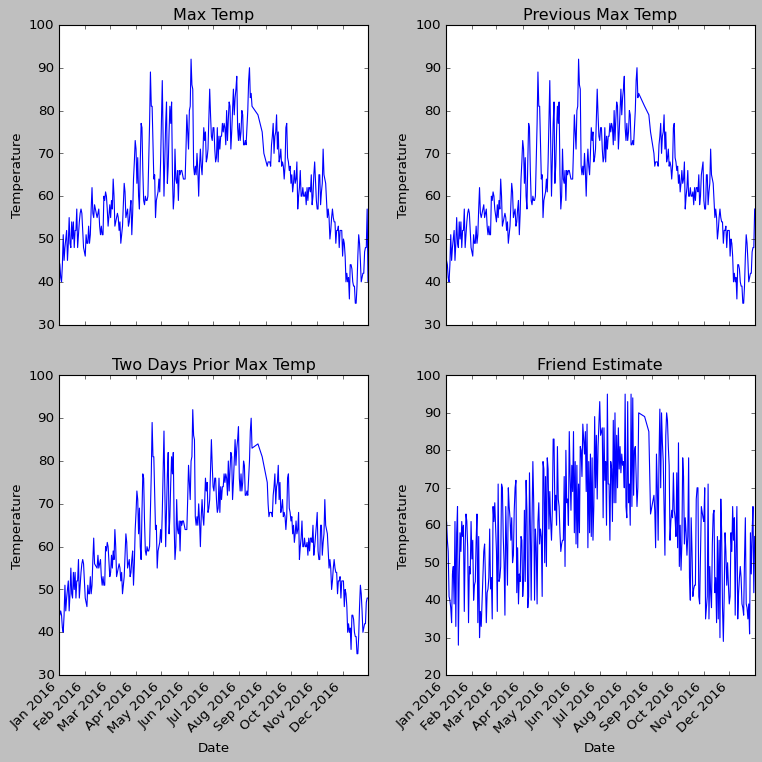

In [93]:
# 准备画图
# 指定默认风格
plt.style.use('classic')

# 设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# 标签值
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# 昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# 前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# 我的逗逼朋友
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

In [94]:
#独热编码
features =pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [95]:
#标签
labels=np.array(features['actual'])
#特征中去掉标签
features=features.drop('actual',axis=1)
#单独保存名字
features_list=list(features.columns)
features_list
#转换格式
features=np.array(features)

In [96]:
features.shape

(348, 14)

In [97]:
#预处理数据-标准化
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)

In [98]:
input_features[0]

array([ 0.        , -1.5678393 , -1.65682171, -1.48452388, -1.49443549,
       -1.3470703 , -1.98891668,  2.44131112, -0.40482045, -0.40961596,
       -0.40482045, -0.40482045, -0.41913682, -0.40482045])

# 构建网络模型

In [99]:
x = torch.tensor(input_features,dtype = float)

y = torch.tensor(labels,dtype = float)

#权重参数初始化
weights = torch.randn((14,128),dtype = float,requires_grad = True)
biases = torch.randn(128,dtype = float,requires_grad = True)
weights2 = torch.randn((128,1),dtype = float,requires_grad = True)
biases2 = torch.randn(1,dtype = float,requires_grad = True)

learning_rate = 0.001
losses=[]

In [100]:
for i in range (1000):
    #计算隐层
    hidden = x.mm(weights) + biases
    #激活函数
    hidden = torch.relu(hidden)
    #预测结果
    predictions = hidden.mm(weights2) + biases2
    #损失函数
    loss = torch.mean((predictions - y) ** 2)
    losses.append(loss.data.numpy())
    
    #打印损失值
    if i%100 == 0:
        print('loss',loss)
    #反向传播算法
    loss.backward()
    
    #更新参数
    weights.data.add_(- learning_rate * weights.grad.data)
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)
    biases2.data.add_(- learning_rate * biases2.grad.data)
    
    #迭代后导数清零
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()
    

loss tensor(5777.9758, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(153.4654, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(146.9469, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(144.8091, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(143.5446, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(142.6685, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(142.0156, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(141.5196, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(141.1421, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(140.8417, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [101]:
predictions.shape

torch.Size([348, 1])

# 更简单的网络模型

In [102]:
input_size = input_features.shape[1]
hidden_size = 128
output_size = 1
batch_size = 16
#搭建网络模型
my_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size,hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size,output_size),
)
cost = torch.nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(my_nn.parameters(),lr = 0.001)

In [103]:
len(input_features)

348

In [104]:
#训练网络
losses=[]
for i in range(1000):
    batch_loss = []
    #MINI-Batch方法训练
    for start in range(0,len(input_features),batch_size):
        end = start + batch_size if start + batch_size < len(input_features) else len(input_features)
        xx = torch.tensor(input_features[start:end],dtype = torch.float,requires_grad =True)
        yy = torch.tensor(labels[start:end],dtype = torch.float,requires_grad =True)
        predictions = my_nn(xx)
        loss = cost(predictions,yy)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        batch_loss.append(loss.data.numpy())
    #打印损失
    if i%100 == 0:
        losses.append(np.mean(batch_loss))
        print(i,np.mean(batch_loss))
        

0 3974.9116
100 37.89209
200 35.639587
300 35.257034
400 35.08058
500 34.941647
600 34.82025
700 34.703487
800 34.58565
900 34.462936


In [107]:
x = torch.tensor(input_features, dtype = torch.float)
predict = my_nn(x).data.numpy()

In [108]:
# 转换日期格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]


In [110]:
# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# 同理，再创建一个来存日期和其对应的模型预测值
months = features[:, features_list.index('month')]
days = features[:, features_list.index('day')]
years = features[:, features_list.index('year')]

test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predict.reshape(-1)})

In [112]:
true_data
predictions_data

,date,prediction
0,2016-01-01,47.522755
1,2016-01-02,47.668163
2,2016-01-03,47.249722
3,2016-01-04,47.166176
4,2016-01-05,47.649437
...,...,...
343,2016-12-27,44.869389
344,2016-12-28,44.766869
345,2016-12-29,46.187748
346,2016-12-30,46.803711


Text(0.5, 1.0, 'Actual and Predicted Values')

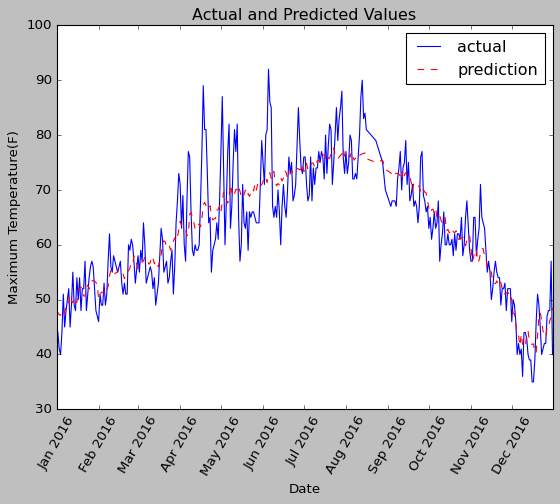

In [118]:
#绘图
#真实值
plt.plot(true_data['date'],true_data['actual'],'b-',label = 'actual')
#预测值
plt.plot(predictions_data['date'],predictions_data['prediction'],'r--',label = 'prediction')
plt.xticks(rotation = '60');
plt.legend()
#图名
plt.xlabel('Date');
plt.ylabel('Maximum Temperature(F)');
plt.title('Actual and Predicted Values')